Stochastic Gradient Descent. 
Init weights. Predict. Calculate loss.
Calculate gradient. 
Step, change the weights. 
Repeat. 

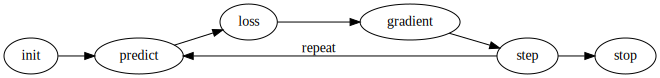

In [122]:
from fastbook import *
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')


Illustrating a loss function

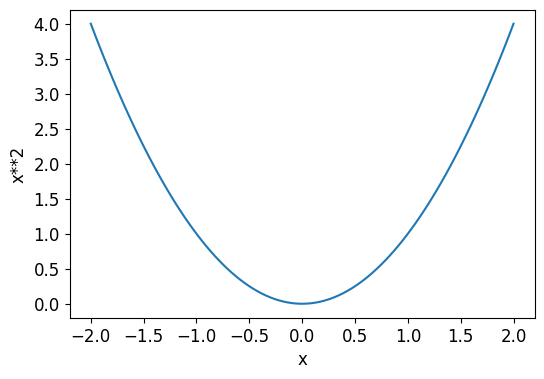

In [123]:
def f(x): return x**2
plot_function(f, 'x', 'x**2')

Pick random value for a starting parameter and calculate value of the loss. 

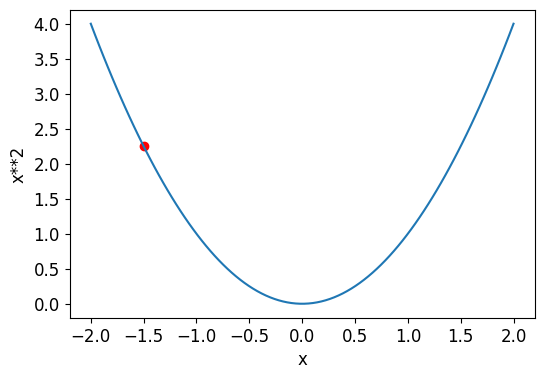

In [124]:
plot_function(f, 'x', 'x**2')
plt.scatter(-1.5, f(-1.5), color='red')

Calculating gradients. 
Pick a tensor value which we want gradients at. 

In [125]:
xt = tensor(3.).requires_grad_()
xt

tensor(3., requires_grad=True)

In [126]:
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

In [127]:
# Backpropagation, to calculate the derivative of each layer. Calculate the gradient. 
yt.backward()

In [128]:
xt.grad

tensor(6.)

Repeat the same but with a vector


In [129]:
xt = tensor([3., 4., 10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

In [130]:
def f(x): return (x**2).sum()

yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

In [131]:
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

End to end Stochastic Gradient Descent


A roller coaster speed as it starts fast, slows towards top of hill, then speeds up again. 

In [132]:
time = torch.arange(0,20).float() 
time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

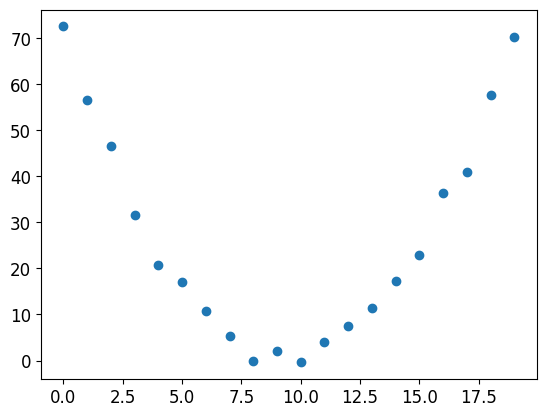

In [133]:
# Random noise 
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time, speed)

Function to take the time being measured, and the quadratic's a,b,c being trained.

In [134]:
def f(t, params):
    a,b,c = params
    return a*(t**2) + (b*t) + c


For continuous data the loss function is mean squared error.

In [135]:
def mean_squared_error(predictions, targets):
    return ((predictions - targets)**2).mean()



Go through the seven-step process. 

In [136]:
# 1. Initialise the params
params = torch.randn(3).requires_grad_()
original_params = params.clone()
original_params

tensor([-0.4749,  1.6640,  0.0110], grad_fn=<CloneBackward0>)

In [137]:
# 2. Calculate predictions. 
predictions = f(time, params)

Function to show how close predictions are to targets.

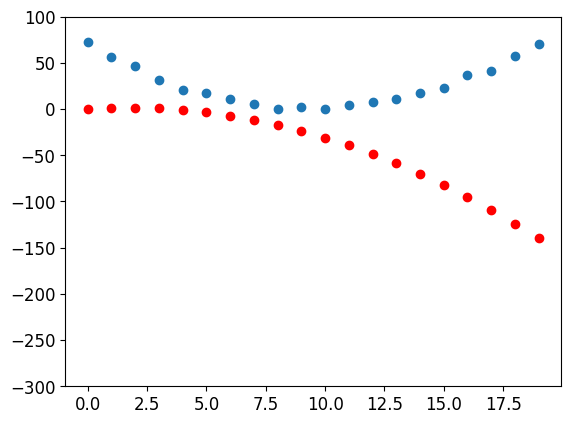

In [138]:
def show_predictions(predictions, ax=None):
    if ax is None:
        ax = plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(predictions), color='red')
    ax.set_ylim(-300, 100)

show_predictions(predictions)

In [139]:
# 3. Now calculate the loss, the goal is to improve this
loss = mean_squared_error(predictions, speed)
loss

tensor(8001.8804, grad_fn=<MeanBackward0>)

In [140]:
# 4. Calculate the gradient - that is, help us figure out how our parameters need to change. 
loss.backward(retain_graph=True)
params.grad

tensor([-28646.8242,  -1808.3682,   -138.8139])

In [141]:
params.grad * 1e-5

tensor([-0.2865, -0.0181, -0.0014])

In [142]:
params

tensor([-0.4749,  1.6640,  0.0110], requires_grad=True)

In [143]:
# 5. Step the weights. Update the parameters based on the above gradients. 
learning_rate = 1e-5
params.data -= learning_rate * params.grad.data
params.grad = None

# We calculated by calling .backward() on loss. 
# Loss was calculated from mean_squared_error, which took predictions as input. 
# predictions was calculated from f taking params. 
# params had requires_grad_ enabled, which is what allows us to call backward on loss. 

# Show new params
params

tensor([-0.1884,  1.6821,  0.0124], requires_grad=True)

In [144]:
# Predict again with the new paramters. 
predictions = f(time, params)
mean_squared_error(predictions, speed)

tensor(2090.1538, grad_fn=<MeanBackward0>)

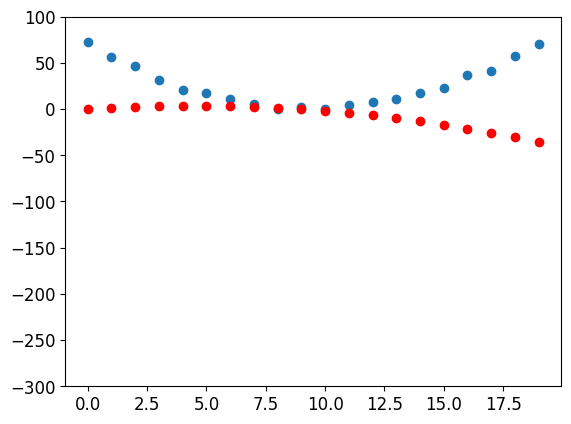

In [145]:
# Show the graph again
show_predictions(predictions)

In [146]:
# To help repeat this, create a function to apply one step

def apply_step(params, prn=True):
    predictions = f(time, params)
    loss = mean_squared_error(predictions, speed)
    loss.backward()
    params.data -= learning_rate * params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return predictions



In [147]:
# 6. Repeat the process. 10 times

for i in range(10):
    apply_step(params)

    

2090.15380859375
971.4664306640625
759.7678833007812
719.6994018554688
712.108642578125
710.6634521484375
710.38134765625
710.3193359375
710.2989501953125
710.2864379882812


In [148]:
# reset
params = original_params.detach().requires_grad_()

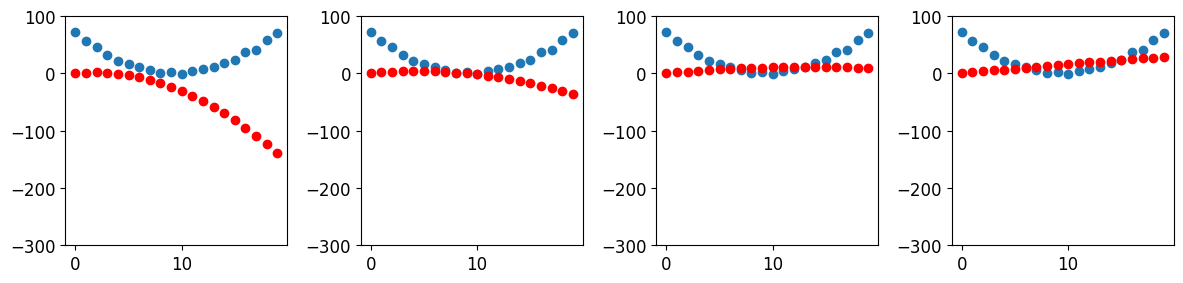

In [149]:
# Run the steps again with visualizations

_,axs = plt.subplots(1,4, figsize=(12,3))
for ax in axs: show_predictions(apply_step(params, False), ax)
plt.tight_layout()

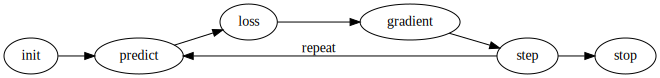

In [152]:
#7. Stop.

# Summarizing:


#hide_input
#id gradient_descent
#caption The gradient descent process
#alt Graph showing the steps for Gradient Descent
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')
     




To summarize, at the beginning, the weights of our model can be random (training from scratch) or come from a pretrained model (transfer learning). In the first case, the output we will get from our inputs won't have anything to do with what we want, and even in the second case, it's very likely the pretrained model won't be very good at the specific task we are targeting. So the model will need to learn better weights.

We begin by comparing the outputs the model gives us with our targets (we have labeled data, so we know what result the model should give) using a loss function, which returns a number that we want to make as low as possible by improving our weights. To do this, we take a few data items (such as images) from the training set and feed them to our model. We compare the corresponding targets using our loss function, and the score we get tells us how wrong our predictions were. We then change the weights a little bit to make it slightly better.

To find how to change the weights to make the loss a bit better, we use calculus to calculate the gradients. (Actually, we let PyTorch do it for us!) Let's consider an analogy. Imagine you are lost in the mountains with your car parked at the lowest point. To find your way back to it, you might wander in a random direction, but that probably wouldn't help much. Since you know your vehicle is at the lowest point, you would be better off going downhill. By always taking a step in the direction of the steepest downward slope, you should eventually arrive at your destination. We use the magnitude of the gradient (i.e., the steepness of the slope) to tell us how big a step to take; specifically, we multiply the gradient by a number we choose called the learning rate to decide on the step size. We then iterate until we have reached the lowest point, which will be our parking lot, then we can stop.

All of that we just saw can be transposed directly to the MNIST dataset, except for the loss function. Let's now see how we can define a good training objective.
